# Summaries of possible thesis topics

## Robustness / Understanding NNs

### **Lottery Ticket Hypothesis** (2019)
(Frankle, Carbin)

#### Methodology

- **Identifying winning tickets**: Train NN and prune smallst-magnitude weights. Each unpruned connection's value is reset to its initialization before training. *Iteratively* do:
    1. Randomly initialize NN $f(x|\theta_0), \quad \theta_0 \sim \mathcal{D_\theta}$
    2. Train NN for $j$ iterations, arriving at parameters $\theta_j$
    3. Prune $p$% of the parameters in $\theta_j$, creating a mask $m$
    4. Reset remaining parameters to their values in $\theta_0$ creating the winning ticket $f(x|m\bigodot\theta_0)$
- **Pruning**: layer-wise heuristic pruning: remove a percentage of the weights with the lowest magnituted within each layer

#### Findings
- **The Lottery Ticket Hypothesis**: *A randomly-initialized, dense NN contains a subnetwork that is initialized s.t. - when trained in isolation - it can match the test accuracy of the orgiginal network after training for at most the same number of iterations*
- **The Lottery Ticket Conjecture**: SGD seeks out and trains a subset of well-initialized weights. Dense, randomly-initialized networks are easier to train than the sparse networks that result from pruning and because there are more possible subnetworks from which training might recover winning tickets
- **FCN** (MNIST)
    - **Random reinitialization**: initialization is crucial for the efficacy of a winning ticket. When randomly reinitialized, they learn progressively slower $\rightarrow$ *the original initialization withstands and benefits from pruning, while the random reinitialization's performance immediately suffers and diminishes steadily*
    - **One-shot pruning**: valid alternative to iterative pruning (esp. with limited computational power), still finds winning tickets. But results from iterative pruning are better
- **CNN** (CIFAR10)
    - **Random reinitialization**: same as above, one exception: test acc at early-stopping time remains steady and improves for Conv-2 and Conv-4: at moderate levels of pruning, the *structure of the winning tickets* alone may lead to better accuracy
    - **Dropout**: Dropout increases initial test accuracy, iterative pruning increases it further. Learning becomes faster. $\rightarrow$ iterative pruning interacts with dropout in a complementary way.
        - Dropout techniques that target weights or learn per-weight dropout probabilities could make winning tickets easier to find
        
#### Discussion
- **Importance of winning ticket initialization**: 
    - When randomly reinitialized, winning ticket learns more slowly and achieves lower test accuracy, suggesting that initialization is important to its success.
    - Possible explanation: Initialized weights already close to optimal value is wrong. They show, that winning ticket weights move further than other weights
    - This suggests, that benefit of initialization is connected to optimization algo, data and model
    - Literature (Liu et al. 2019) show that pruned networks are trainable when reinitialized randomly, contradicting the above statements
- **Importance of winning ticket structure**: 
    - Hypothesize, that structure of winning tickets encodes an inductive bias customized to the learning task at hand.
    - Literature (Cohen & Shashua 2016) show that inductive bias embedded in the structure of a DNN determine the kinds of data that it can seperate more parameter-efficiently than can a shallow network
- **Improved generalization of winning tickets**:
    - Winning tickets generalize better (*Occam's Hill*: test acc increases, then decreases)
    - Conventional view: ocmpact hypotheses can generalize better
    - Literature (Zhou et al. 2018): tighter generalization bounds for networks can be compressed further
- **Implications of NN optimization**:
    - Role of overparameterization in NN training: suffciently overparam. two-layer relu networks trained with SGD converge to global optima
    - Key question: Presence of a winning ticket necessary or sufficient for SGF to optimize a NN?
        - Conjecture: SGD seeks out and trains well-initialized subnetwork. Overparam. NN are easier to train because they have more combinations of subnetworks that are potential winning tickets

#### Future Work
- Explore more efficient methods for finding winning tickets (here: iterative pruning) to study hypothesis in more resource-intensive settings
- Study pruning methods, such as structured pruning and non-magnitute pruning (here: parameter-count reduced but resulting architectures not optimized for modern libraries/hardware). Goal: find smaller winning tickets or find them earlier 
- Study properties of initialization that, in concert with inductive biases of pruned NN architectures, makes these networks particularly adept at learning
- Explore why warmup (on deeper networks) is necessary to find winning tickets. Are there other improvements to their scheme for identifying winning tickets? Hyperparam. modifications?

___________________________________________

### **Linear Mode Connectivity and the Lottery Ticket Hypothesis** (2020)
(Frankle, Dzuigiate, Roy, Carbin)

*How much variability does data order randomness (SGD noise) induce in the optimization trajectories of NN and the role this variability plays in sparse, LT networks i.e. when is a NN robust to data order*

#### Methodology

- **Instability Analysis**: Determine whether outcome of optimization is robust to different samples of SGD Noise
    1. Create a NN with random init $W_0$ (or after $k$ iterations $W_k$)
    2. Train two copies of this network in parallel on different data orders, resulting in $W^1_T$ and $W^2_T$ after T steps (or T-k steps)
    3. Measure effect of these "different" samples by comparing the resulting networks
        - Compare trained NNs by studying the optimization landscape along the line (linear interpolation) between $W^1_T$ and $W^2_T$
        - *instability* of the NN to SGD noise: maximum increase in test error along this linear path.
        - This interpolation is also called *mode connectivity*: Phenomenon where the minima found by two networks are connected by a path of constant error
    - Data: MNIST, CIFAR10, ImageNet

- **Instability and LT**
    - *iterative magnitude pruning* (IMP), used in the original LT paper (above) does not find LT tickets in more challening settings
        1. train NN
        2. prune weights with lowest magnitudes globally
        3. rewind remaining weights back to their init value at iteration $k$ (originally $k = 0$)
        4. Repeat
    - In this work: k can be nonzero, therefore "winning tickets" are here called "matching" (since NNs are no longer randomly initialized)

#### Findings

- **NN Instability to SGD Noise**
    - Lenet is stable at init, every networks becomes stable early in training: test set instability decreases as k (epoch where we split NN) increases
- **Instability and LT**
    - The sparset IMP subnetworks only train to full accuracy when they are stable
        - contrast: unpruned networks seems unaffected by instability
    - $k = 0$ (i.e. going back to Iteration 0)
        - Lenets and Resnet20/VGG16 with lower lr and warmup are matching - they are also stable!
        - Larger NNs are not matching (performance drops to random masking)
        - No randomly pruned or reinitialized subnetworks are stable or matching except Lenet **Why?? The results above seem like randomness matters. *This suggests that there is an undiscovered process***
    - $k > 0$
        - Randomly pruned and reinitialized subnetworks are unstable and non-matching at all rewinding points
        - NNs whose IMP subnetworks were stable with $k=0$ remain so
        - NNs whose IMP subnetworks were matching with $k=0$ remain so (generally)
        - NNs whose IMP subnetworks were unstable when rewinding to iteration become stable when rewinding later
        - NNs whose IMP subnetworks were not matching when rewinding to iteration become matching when rewinding later
        - Rewinding points where subnetworks become matching coincide with those where subnetworks become stable
        - *Subnetworks are matching when they are stable*

#### Discussion

- **Instability Analysis**
    - Two Phases: 
        - Unstable Phase: Networks finds linearly unconnected minima due to SGD noise
        - Stable Phase: linearly connected minimum is determined
    - stability emerges early in training
- **Lottery Ticket Hypothesis**
    

___________________________________________

### **Are All Layers Created Equal?** (2019)
(Zhan, Bengio, Singer)

#### Methodology
Authors train different NNs (FC, VGG, ResNet) on different datasets and examine how "important" a specific layer is for prediction:
- **Re-initialization**: A specific layer is re-initialized to its weights before training. Everything else stays the same. *re-initialization robustness* is measured by test error
- **Re-randomization**: re-sample random values in a specific layer. *re-randomization robustness* is also measured by test error
- Layers with high robustness are called **ambient** (i.e. they do not really play a major role in prediction) and **critical** (i.e. important for good prediction)

#### Findings
- **FCN**
    - **re-randomizing** any of the layers completely disintegrates representation and classification accuracy drops to level of random guessing
    - **re-initialization**: first layer very sensitive, the rest of the layers are robust to re-initialization
    - *robustness to re-initialization does not oviously correlate with distances between trained and untrained weights* $\rightarrow$ gradient norms increase during backprob s.t. first layers are being updated more aggressivly than top ones **not** an explanation (no smooth transition of robustness)
    - $\rightarrow$ *Over-capacitating DNN trained with SGD have low-complexity due to self-restriction of the number of critical layers*
    - The following image shows the same analysis for a large number of different configurations (MNIST and CIFAR10)
        - MNIST
            - top layers ("later" layers) become more robust as hidden dimensions increase
            - capacity small $\rightarrow$ all layers are vigil participants in representing the prediction function
            - as capacity increases, using bottom layer suffices while the rest act as random projections with non-linearities
        - CIFAR10
            - same as MNIST but not as pronounced
   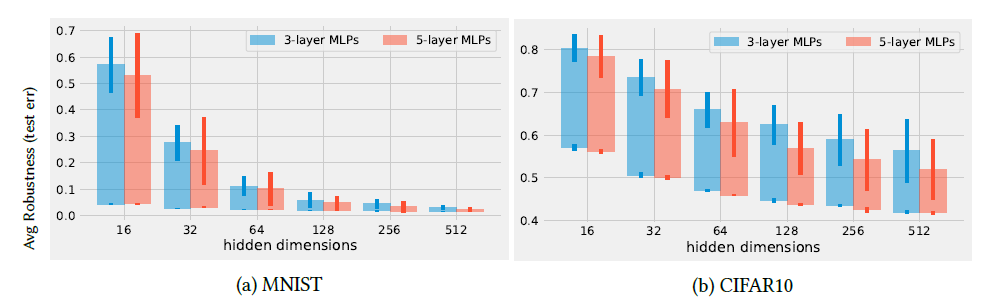

- **ResNet & VGG**
    - VGGs more sensitive to re-initialization (similar patterns as FC)
    - ResNets
        - re-distribute critical layers (across network)
        - residual blocks can be robust to re-randomization: Among the layers, that are robust to re-initialization, if the layer is a residual block, it is also robust to re-randomization
- **Joint Robustness**
    - Experiments
        1. Refrain from training layers and leave their parameters at randomly initialized values
        2. Remove layers form the network
    - Results
        - CIFAR10: Similar performance when layers removed entirely
        - ImageNet: Removal results in significant performance gap

**$\rightarrow$ Random projections followed by non-linear activations conduced by frozen layers seem necessary to maintain accuracy** (see section of "re-shaping" nets)

___________________________________________

### **Deconstructing Lottery Tickets** (2020)
(Zhou, Lan, Liu, Yosinski)

#### Methodology

Paper follows the experiments of the original LT paper and try to answer the following question with experiments that vary from the original:
- What about LT networks causes them to show better performance?
- Why are the mask and the initial weights so tightly coupled, s.t. re-initializing the network makes it less trainable?
- Why does simply selecting large weights constitute an effective criterion for choosing a mask?

3 approaches (experiments on MNIST (FC3) and CIFAR10 (Conv-2/4/6)):
- **Mask criteria** (i.e. functions that decide which weights to prune vs. keep)
    - *large_final* (original paper): keep those with largest values *after training*
    - *small_final*: keep those with smallest values *after training*
    - *large_init*: keep those with largest values *at init*
    - *small_init*: keep those with smallest values *at init*
    - *large_init_large_final*: combination of the two "large" above
    - *small_init_small_final*: combination of the two "small" above
    - *magnitude_increase*: keep those, that get "biggest"
    - *movement*: keep those, that move most (i.e. get "biggest" in absolute value)
    - *random*
- **Mask-1 actions** (i.e. take action with weights with mask == 1)
    - *re-init*: Reinitialize kept weights based on original init dist
    - *re-shuffle*: reinit while respecting the original dist of remaining weights in that layer by reshuffling the kept weights initial values
    - *constant*: reinitialize by setting 1-masked weight values to a positive or negative constant $\rightarrow$ every weight on a layer becomes one of three values: $-\alpha$,0,$\alpha$, $\alpha$ being the std of each layers original init
- **Mask-0 actions** (i.e. take actions with weights with mask == 0)
    - Expectation: "If the value of zero for the pruned weights is not important to the performance of the network, we should expect that we can set pruned weights to some other value, such as leaving them frozen at their initial values, without hurting the trainability of the network. $\rightarrow$ *not the case! zero values matter*
    - Experiments:
        - reproduce the LT iterative pruning experiments: network weights are masked out in alternating train/mask/rewind cycles
        - addidionally: freeze masked weights at their initial values instead of at zero
        - To test the hypothesis stated below: 
            - V1: for any zero-masked weight, freeze it to zero if it moves toward zero over the course of training
            - V2: extension for one-masked weights: initialize every weight to zero if they move toward zero during training, regardless of the pruning action

These experiments result in a **Supermask**: Masks, that produce better-than-chance accuracy without training of the underlying weights
- **Supermask**
    - Gather all masks instantiated in the process of creating the networks above, then apply them to the original, randomly initialized networks and evaluate the accuracy without training the network
    - new mask criterion *large_final_same_sign*: selects weights with large final magnitudes that maintained to same sign by the end of training
- **Training the Supermask**
    - trainable mask for each layer while freezing all original parameters. Train mask with Bernoulli sampler with probability $p$ and sigmoid function

#### Findings
Experiment stays the same with the exception of the described changes in each section
- **Mask criteria**
    - In each of the opposing paris: when one member of the pair performs better than the random baseline, the opposing member performs worse than it
    - *magnitude_inctrease* and *large_final* work well, in some cases the former works (significantly) better
    **Conclusion**: LT behaviour is not limited to *large_final*
- **Mask-1 actions** 
    - None of the variants alone able to train as well as original LT network
    - All variants work better when ensuring, that new values of kept weights are *of the same sign* as their original values
    - **Conclusion**: Optimizers work well anywhere in the correct sign quadrant for the weights, but encounter difficulty crossing the zero barrier between signs
- **Mask-0 actions**
    - *masking can be viewed as a way of training*: masking op tends to move weights in the direction they would have moved during training
    - Networks perform significantly better when weights are frozen, esp. at zero than at random initial values
    - *Hypothesis*: Mask criterion tends to mask to zero those weights that were headed toward zero anyway
    - V2 performs better than V1 in testing the hypothesis: mask-0 action can be a beneficial mask-1 action, too. 
    - **Conclustion**: Results support hypothesis. Furthermore:
        - explains why certain mask criterias work so well
        - explains important contribution of the value of pruned weights to the overall performance of pruned networks
        - explains the benefit of setting these select weights to zero as a better initialization for the network
- **Supermask**
    - large_final_same_sign outperforms other mask criteria (accuracy at init): 80% test acc on MNIST, 24% CIFAR10
    - apply mask to a signed constant (mask-1 action), even better: 86% MNIST, 41% CIFAR10
    - method of network compression: only need to save binary mask and single random seed to reconstruct weights
- **Training Supermask**
    - 95.5% acc on MNIST, 65.4% CIFAR10
    - *Dynamic weight rescaling*: dynamically rescale values of weights based on sparsity of network in current training iteration: significant improvements
    - **Conclustion**: Network upon initialization already contains powerful subnetworks that work well without training

    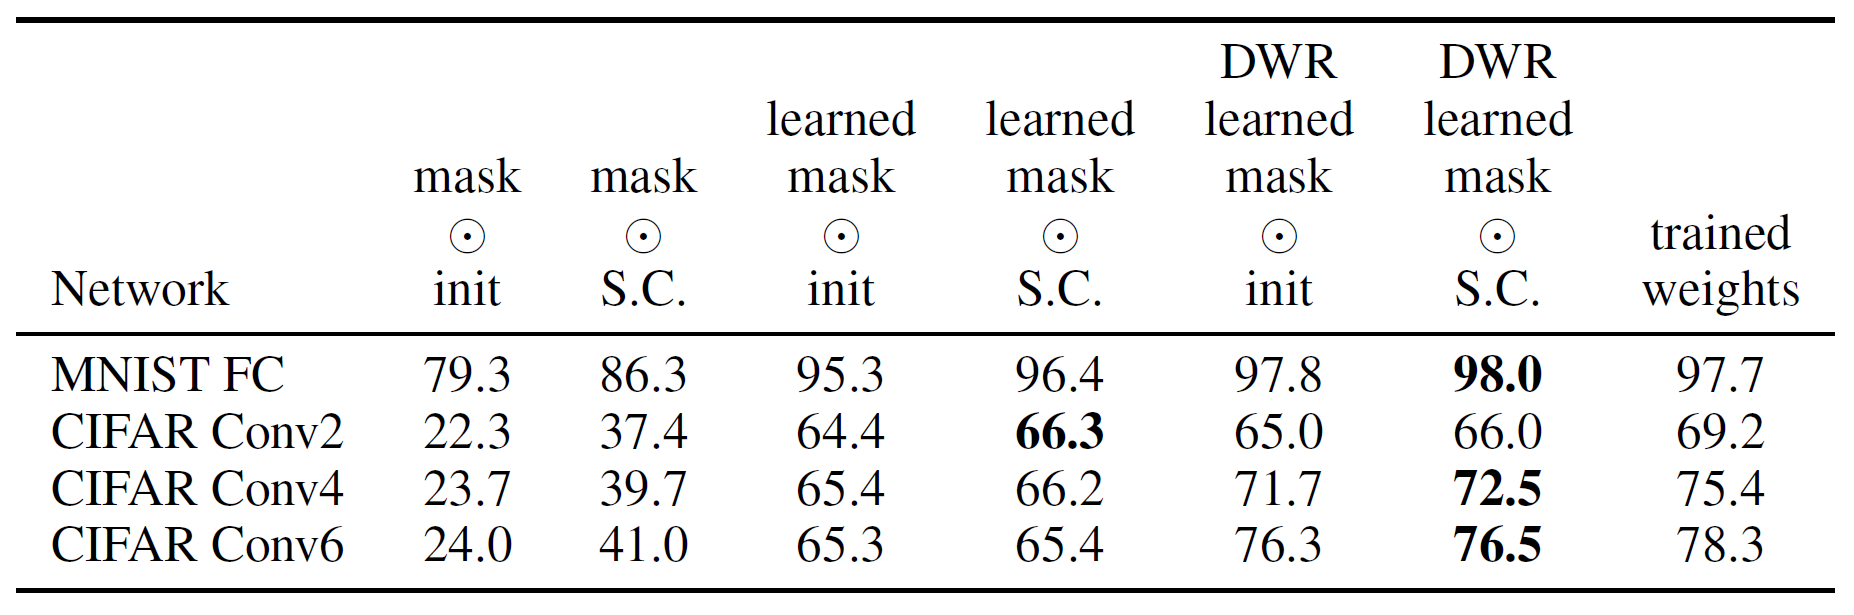

___________________________________________

## Ideas

- **Prune Word2Vec**
    - More efficient training and usage
    - Interpretation of dimensions (semantic,...)
- **Prune (Variational)-Autoencoder**
    - Sparse-Autoencoder: KL-Term in loss function (i.e. find sparsity by optimizing loss)
    - $\rightarrow$ Find sparsity with mask, not loss
- **Prune during training**
    - Network gets trained iteratively anyways, so is it possible to prune network on the fly?
    - Investigate "journey" of weights that are being pruned
    - paper already exist, maybe future work?
- **Initialize better**
    - Apparently initialization plays a big part. So why not initialize weights better from the get go?
    - what is the role of initialization? experiment with different initializers
- **Adverserial Attacks**
    - are there any adverserial attacks for nlp or structured data? does that even make sense?
- **Link between subnetworks stability and accuracy**
    - IMP subnetworks are matching and become stable at least as early as the full networks, while other subnetworks are less accurate and unstable for the sparsities and rewinding points they considered
- **Explore Chaning aspects of optimization**
    - Minimize time spent in Phase 1 and termine during training that Phase 2 started?
    - Learning rate schedule, optimizer,...
- **Train Supermask**
    - initialize large network and instead of training weights, train a (binary) mask (on the fly)
    - genetic algorithm? 
- **Mask vs. Initialization**
    - how do the two correspond to one another?

## Questions
- **Randomness** (are all layers created equal)
    - Why does it matter if you leave layers in although they are ambient? If randomness plays such an important role, can we not be more fficient with architectures, training (maybe genetic algos?),...??